<a href="https://colab.research.google.com/github/emery1189/big-cat-classifier/blob/main/big_cat_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Cat Classification

using a [Kaggle dataset](https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification), we are going to create a classifaction model that will predict the species of big cat (among 10 classes).

we will:
1. import data into colab notebook
2. preprocess image data into numbers
3. create a simple CNN (Convolutional Neural Network) to train and evaluate
4. use an EfficientNet to train and evaluate  
5. `big_cat_classify()` uploaded images

## getting data

[Kaggle's guide to getting datasets into colab](https://www.kaggle.com/general/74235)

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download gpiosenka/cats-in-the-wild-image-classification

 97% 120M/123M [00:08<00:00, 18.6MB/s]
100% 123M/123M [00:08<00:00, 15.3MB/s]


In [5]:
!unzip /content/cats-in-the-wild-image-classification.zip

Archive:  /content/cats-in-the-wild-image-classification.zip
  inflating: EfficientNetB0-10-(224 X 224)-100.00.h5  
  inflating: MobileNetV3 small-10-(224 X 224)-95.96.h5  
  inflating: WILDCATS.CSV            
  inflating: test/AFRICAN LEOPARD/1.jpg  
  inflating: test/AFRICAN LEOPARD/2.jpg  
  inflating: test/AFRICAN LEOPARD/3.jpg  
  inflating: test/AFRICAN LEOPARD/4.jpg  
  inflating: test/AFRICAN LEOPARD/5.jpg  
  inflating: test/CARACAL/1.jpg      
  inflating: test/CARACAL/2.jpg      
  inflating: test/CARACAL/3.jpg      
  inflating: test/CARACAL/4.jpg      
  inflating: test/CARACAL/5.jpg      
  inflating: test/CHEETAH/1.jpg      
  inflating: test/CHEETAH/2.jpg      
  inflating: test/CHEETAH/3.jpg      
  inflating: test/CHEETAH/4.jpg      
  inflating: test/CHEETAH/5.jpg      
  inflating: test/CLOUDED LEOPARD/1.jpg  
  inflating: test/CLOUDED LEOPARD/2.jpg  
  inflating: test/CLOUDED LEOPARD/3.jpg  
  inflating: test/CLOUDED LEOPARD/4.jpg  
  inflating: test/CLOUDED LEOPA

<font size=8>🛠️🪛🪚</font>

imports

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from IPython.display import Image
from matplotlib.pyplot import imread

<font size=8>🔎</font>

let's have a wee look at the data

In [7]:
wildcats = pd.read_csv("/content/WILDCATS.CSV")

wildcats.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/AFRICAN LEOPARD/001.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
1,0,train/AFRICAN LEOPARD/002.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
2,0,train/AFRICAN LEOPARD/003.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
3,0,train/AFRICAN LEOPARD/004.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
4,0,train/AFRICAN LEOPARD/005.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus


excellent! we have a dataframe containing each filepath and its associated label.

how many samples of each cat species do we have?

In [8]:
wildcats["labels"].value_counts()

JAGUAR             248
TIGER              247
AFRICAN LEOPARD    246
CARACAL            246
PUMA               246
CHEETAH            245
OCELOT             243
SNOW LEOPARD       241
CLOUDED LEOPARD    239
LIONS              238
Name: labels, dtype: int64

<font size=8>⚖️</font>  

we've got balanced data.

how big is each data set?

In [9]:
wildcats["data set"].value_counts()

train    2339
test       50
valid      50
Name: data set, dtype: int64

<font size=8>📸</font>

let's look at a few images

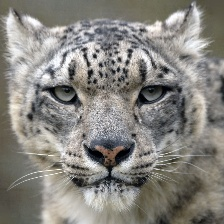

In [10]:
Image("/content/train/SNOW LEOPARD/017.jpg")

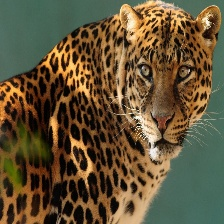

In [11]:
Image("/content/train/JAGUAR/028.jpg")

## preprocessing data

we need a list of filenames for each image as they appear here in our colab notebook.

In [12]:
# create filenames from images IDs using list comprehension

filenames = ["/content/" + fname for fname in wildcats["filepaths"]]

# check filenames
filenames[:5]

['/content/train/AFRICAN LEOPARD/001.jpg',
 '/content/train/AFRICAN LEOPARD/002.jpg',
 '/content/train/AFRICAN LEOPARD/003.jpg',
 '/content/train/AFRICAN LEOPARD/004.jpg',
 '/content/train/AFRICAN LEOPARD/005.jpg']

In [13]:
len(filenames)

2439

2339 train + 50 valid + 50 test

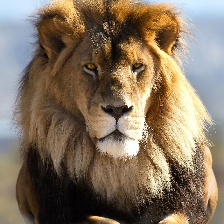

In [14]:
Image(filenames[1179])

<font size=8>🚂 🧪 ✅</font>

train, test, and validation sets

this data is already organized into train test and validation sets, so we can use simple indexing to create our `X_train`, `X_test`, `X_valid`.

In [15]:
filenames[2339]

'/content/test/AFRICAN LEOPARD/1.jpg'

In [16]:
filenames[2389]

'/content/valid/AFRICAN LEOPARD/1.jpg'

In [17]:
X_train, X_test, X_valid = filenames[:2338], filenames[2339:2388], filenames[2389:]

In [18]:
X_train[-1], X_test[0], X_valid[0]

('/content/train/TIGER/236.jpg',
 '/content/test/AFRICAN LEOPARD/1.jpg',
 '/content/valid/AFRICAN LEOPARD/1.jpg')

getting our labels into *booleans*


In [19]:
ids = wildcats["class id"]

# use numpy to turn into array
ids = np.array(ids)
ids

array([0, 0, 0, ..., 9, 9, 9])

In [20]:
unique_ids = np.unique(ids)
boolean_labels = [id == unique_ids for id in ids]

# random sample
boolean_labels[17]

array([ True, False, False, False, False, False, False, False, False,
       False])

now let's get our `y_train`, `y_test`, and `y_valid`.

In [21]:
y_train, y_test, y_valid = boolean_labels[:2338], boolean_labels[2339:2388], boolean_labels[2389:]

In [22]:
species_dict = {0: 'AFRICAN LEOPARD',
                1: 'CARACAL',
                2: 'CHEETAH',
                3: 'CLOUDED LEOPARD',
                4: 'JAGUAR',
                5: 'LIONS',
                6: 'OCELOT',
                7: 'PUMA',
                8: 'SNOW LEOPARD',
                9: 'TIGER'}

it's time to get our images into numbers!

In [23]:
# read an image and check shape

image = imread(filenames[442])
image.shape

(224, 224, 3)

In [24]:
# turn that image into a tensor

tf.constant(image)

<tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[228, 158,  98],
        [228, 158,  98],
        [226, 158,  97],
        ...,
        [208, 162, 102],
        [203, 158,  99],
        [200, 155,  96]],

       [[228, 158,  98],
        [227, 157,  97],
        [226, 158,  97],
        ...,
        [207, 161, 101],
        [202, 157,  98],
        [200, 155,  96]],

       [[228, 158,  98],
        [227, 157,  97],
        [226, 158,  97],
        ...,
        [206, 160, 100],
        [202, 157,  98],
        [200, 155,  96]],

       ...,

       [[186, 125,  71],
        [188, 127,  73],
        [188, 127,  73],
        ...,
        [156, 112,  67],
        [157, 112,  70],
        [155, 110,  68]],

       [[188, 125,  72],
        [189, 126,  73],
        [188, 127,  73],
        ...,
        [156, 112,  67],
        [157, 112,  70],
        [155, 110,  68]],

       [[188, 125,  72],
        [189, 126,  73],
        [189, 128,  74],
        ...,
        [156, 112,  6

we'll use a `process_image()` function do the above to each of our images. it will also normalize values and ensure all image sizes are (224, 224).

we'll use a `get_image_label()` function to return pairs of processed images and their boolean labels.

In [25]:
IMG_SIZE = 224


def process_image(image_path):
  """processes an image into normalized float32 values of size (224, 224)"""
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image


def get_image_label(image_path, label):
  """ takes an images file path name and the associated label, processess the image (using our previous function) and returns a tuple of (image, label)"""
  image = process_image(image_path)
  return image, label

In [26]:
# testing our function

image, label = get_image_label(filenames[333], boolean_labels[333])
image, label

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.11764707, 0.18039216, 0.07450981],
         [0.1137255 , 0.1764706 , 0.07058824],
         [0.11764707, 0.17254902, 0.07450981],
         ...,
         [0.14117648, 0.1764706 , 0.10980393],
         [0.13333334, 0.1764706 , 0.10980393],
         [0.13333334, 0.1764706 , 0.10980393]],
 
        [[0.14117648, 0.20392159, 0.09803922],
         [0.13333334, 0.19607845, 0.09019608],
         [0.12941177, 0.18431373, 0.08627451],
         ...,
         [0.14117648, 0.1764706 , 0.10980393],
         [0.14117648, 0.1764706 , 0.10980393],
         [0.13333334, 0.1764706 , 0.10980393]],
 
        [[0.15686275, 0.21960786, 0.1137255 ],
         [0.14901961, 0.21176472, 0.10588236],
         [0.14117648, 0.20392159, 0.09803922],
         ...,
         [0.14509805, 0.18039216, 0.1137255 ],
         [0.14509805, 0.18039216, 0.1137255 ],
         [0.14509805, 0.18039216, 0.1137255 ]],
 
        ...,
 
        [[0.18039216, 0.34509805

we'll use a function `create_data_batches()` to get our data into batches.

we'll use this function to create our `train_data`, `test_data`, and `valid_data`.

In [27]:
BATCH_SIZE = 32

# create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  creates batches of data out of image (X) and label (y) pairs.
  shuffles training data but not validation data.
  also accepts test data as input (no labels).
  """
  # if the data is a test dataset, we certainly don't have labels
  if test_data:
    print("creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))  # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a validation dataset, we don't need to shuffle it
  elif valid_data:
    print("creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                               tf.constant(y)))  # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("creating training data batches...")
    # turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # shuffle path names and labels before mapping image processor function (faster than shuffling images)
    data = data.shuffle(buffer_size=len(X))

    # create (image, label) tuples (which, of course, includes turning the image path into a preprocessed image from our first function)
    data = data.map(get_image_label)

    # turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

In [28]:
# create data batches:

train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)
test_data = create_data_batches(X_test, test_data=True)

creating training data batches...
creating validation data batches...
creating test data batches...


## CNN model

our data is ready to go!

it's time to create a model and fit.

we'll use a simple Conv2D model to get up and running quickly.

In [29]:
# let's create a model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224, 224, 3])),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Epoch 1/10
74/74 [==============================] - 13s 35ms/step - loss: 2.0912 - accuracy: 0.2246 - val_loss: 1.8869 - val_accuracy: 0.3400
Epoch 2/10
74/74 [==============================] - 2s 31ms/step - loss: 1.6594 - accuracy: 0.3837 - val_loss: 1.4454 - val_accuracy: 0.4800
Epoch 3/10
74/74 [==============================] - 2s 31ms/step - loss: 1.4128 - accuracy: 0.4932 - val_loss: 1.3948 - val_accuracy: 0.4400
Epoch 4/10
74/74 [==============================] - 3s 34ms/step - loss: 1.2647 - accuracy: 0.5496 - val_loss: 1.3961 - val_accuracy: 0.5200
Epoch 5/10
74/74 [==============================] - 2s 33ms/step - loss: 1.0673 - accuracy: 0.6313 - val_loss: 1.4722 - val_accuracy: 0.4600
Epoch 6/10
74/74 [==============================] - 2s 32ms/step - loss: 0.8592 - accuracy: 0.7151 - val_loss: 1.4974 - val_accuracy: 0.4600
Epoch 7/10
74/74 [==============================] - 2s 30ms/step - loss: 0.6491 - accuracy: 0.7985 - val_loss: 1.5512 - val_accuracy: 0.4200
Epoch 8/10
7

In [30]:
model.evaluate(valid_data)

2/2 [==============================] - 0s 21ms/step - loss: 1.9540 - accuracy: 0.4600


[1.9539761543273926, 0.46000000834465027]

In [31]:
test_preds = model.predict(test_data)

2/2 [==============================] - 0s 174ms/step


In [32]:
test_preds[0]

array([7.7399534e-01, 1.6895622e-11, 6.8230629e-02, 1.3208593e-03,
       1.2817994e-01, 1.5501620e-09, 9.8717818e-03, 1.1094594e-10,
       6.0401959e-03, 1.2361223e-02], dtype=float32)

In [33]:
species_dict[test_preds[0].argmax()]

'AFRICAN LEOPARD'

In [34]:
list_of_preds = []

for pred in test_preds:
  list_of_preds.append(species_dict[pred.argmax()])

In [35]:
list_of_y_test_labels = [i.split("/")[3] for i in filenames[2339:2388]]

In [36]:
score = 0

for i in range(len(list_of_preds)):
  if list_of_preds[i] == list_of_y_test_labels[i]:
    score += 1

print(f"test accuracy: {round(score / 49 * 100, 2)}")

test accuracy: 38.78


our model only scored 46% on the validation data and 39% on the test data.

let's use a tool that already exists.

## EfficientNet model

we'll create a model using [TensorFlow Hub](https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2).


In [37]:
MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2"


model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

history_2 = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Epoch 1/10
74/74 [==============================] - 16s 78ms/step - loss: 0.6817 - accuracy: 0.7930 - val_loss: 0.1014 - val_accuracy: 1.0000
Epoch 2/10
74/74 [==============================] - 3s 46ms/step - loss: 0.1820 - accuracy: 0.9500 - val_loss: 0.0670 - val_accuracy: 1.0000
Epoch 3/10
74/74 [==============================] - 4s 54ms/step - loss: 0.1381 - accuracy: 0.9624 - val_loss: 0.0658 - val_accuracy: 0.9800
Epoch 4/10
74/74 [==============================] - 4s 54ms/step - loss: 0.1099 - accuracy: 0.9756 - val_loss: 0.0513 - val_accuracy: 1.0000
Epoch 5/10
74/74 [==============================] - 3s 45ms/step - loss: 0.0942 - accuracy: 0.9778 - val_loss: 0.0585 - val_accuracy: 0.9800
Epoch 6/10
74/74 [==============================] - 3s 46ms/step - loss: 0.0858 - accuracy: 0.9786 - val_loss: 0.0555 - val_accuracy: 0.9800
Epoch 7/10
74/74 [==============================] - 4s 54ms/step - loss: 0.0760 - accuracy: 0.9812 - val_loss: 0.0566 - val_accuracy: 0.9800
Epoch 8/10
7

In [38]:
model.evaluate(valid_data)

2/2 [==============================] - 0s 45ms/step - loss: 0.0463 - accuracy: 1.0000


[0.04627836123108864, 1.0]

In [39]:
preds = model.predict(test_data)

2/2 [==============================] - 2s 860ms/step


In [40]:
list_of_preds = []

for pred in preds:
  list_of_preds.append(species_dict[pred.argmax()])

In [41]:
score = 0

for i in range(len(list_of_preds)):
  if list_of_preds[i] == list_of_y_test_labels[i]:
    score += 1

print(f"test accuracy: {round(score / 49 * 100, 2)}")

test accuracy: 100.0


In [42]:
list_of_preds == list_of_y_test_labels

True

<font size=8>🎯</font>

the model is crushing the test and validation data.

how does it do on an uploaded image?

## big cat classify! (testing with uploaded images)

we'll use a `big_cat_classify()` function to take in an image and predict its species.

In [43]:
def load_and_prep_image(filename, img_shape=224):
  """
  reads an image from filename, turns it into a tensor and reshapes to (img_shape, img_shape, color_channels)
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(images=img,
                        size=[img_shape, img_shape])
  img = img / 255.
  return img

def big_cat_classify(imagepath):
  image_tensor = load_and_prep_image(imagepath)
  pred = model.predict(tf.expand_dims(image_tensor, axis=0))
  plt.imshow(image_tensor)
  plt.axis(False)
  plt.title(species_dict[pred.argmax()]
);

1/1 [==============================] - 1s 627ms/step


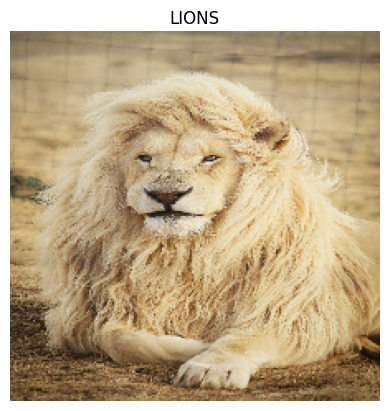

In [44]:
big_cat_classify("/content/arleen-wiese-2vbhN2Yjb3A-unsplash.jpg")

1/1 [==============================] - 0s 26ms/step


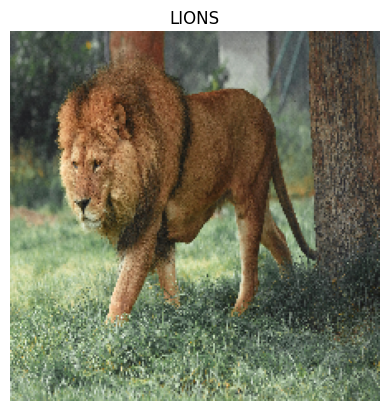

In [45]:
big_cat_classify("/content/francesco-ZxNKxnR32Ng-unsplash.jpg")

1/1 [==============================] - 0s 32ms/step


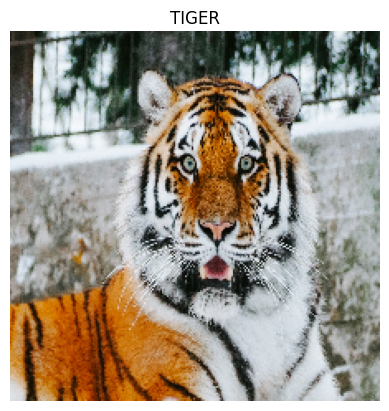

In [46]:
big_cat_classify("/content/max-van-den-oetelaar-S0txA-JnUFA-unsplash.jpg")

1/1 [==============================] - 0s 25ms/step


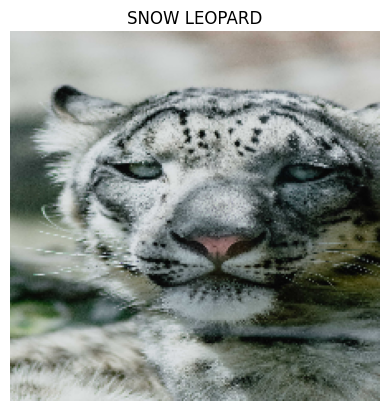

In [47]:
big_cat_classify("/content/latrach-med-jamil-wS2TfbwkmRQ-unsplash.jpg")